In [3]:
from pathlib import Path
from PIL import Image
import torch
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
from torch.utils.data import Dataset
import numpy as np
import warnings
from tqdm import tqdm
import h5py
import json
from notebooks.utils import get_panorama, vis_panorama_window_weighted, get_model
import pickle
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0")

In [3]:
# load pretrained weights
model_path = Path("../logs/brca_hipt_20x/")
model, config = get_model(model_path, device, "last.ckpt")

Loading model from ../logs/brca_hipt_20x/checkpoints/last.ckpt


/home/ysrikar/miniconda3/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 960, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 960, conte

In [4]:
class LargeImageDataset(Dataset):
    def __init__(self, root, ):
        root = Path(root)
        self.image_root = root / "pyramid"
        self.patches = np.load(root / "patch_list_20x.npy")
        features = h5py.File(root / "ssl_features/features_hipt_ctr.h5", "r")
        self.features = features["feat_20x"]

    def __len__(self):
        return len(self.patches) // 20

    def __getitem__(self, idx):
        idx_20x = idx * 16

        img_20x_large = np.ones((1024, 1024, 3))
        images = [Image.open(self.image_root / item) for item in self.patches[idx_20x : idx_20x + 16]]
        order = np.array([0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15]).reshape(4, 4)
        for i in range(4):
            for j in range(4):
                elem = order[i, j]
                img_20x_large[i * 256 : (i + 1) * 256, j * 256 : (j + 1) * 256] = images[elem]
        img_20x_large = Image.fromarray(img_20x_large.astype(np.uint8))

        f = self.features[idx_20x : idx_20x + 16]
        return {"feat_20x": f, "img_20x_large": np.array(img_20x_large)}


In [5]:
root = Path("/data10/shared/srikar/fall23/cocentric_brca")
ds = LargeImageDataset(root)

In [6]:
indices = np.random.choice(len(ds), 15, replace=False)

In [7]:
items = []

for i in tqdm(indices):
    batch = ds[i]
    items.append(batch)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.63it/s]


In [8]:
with open("./dataset_samples/brca_hipt_large_images.pickle", "wb") as f:
    pickle.dump(items, f)

## Generate large images

In [30]:
with open("./dataset_samples/brca_hipt_large_images.pickle", "rb") as f:
    items = pickle.load(f)

In [33]:
batch = items[1]

with torch.no_grad():
    xs = get_panorama(model, batch["feat_20x"])
    panorama_slerp = vis_panorama_window_weighted(xs, model)

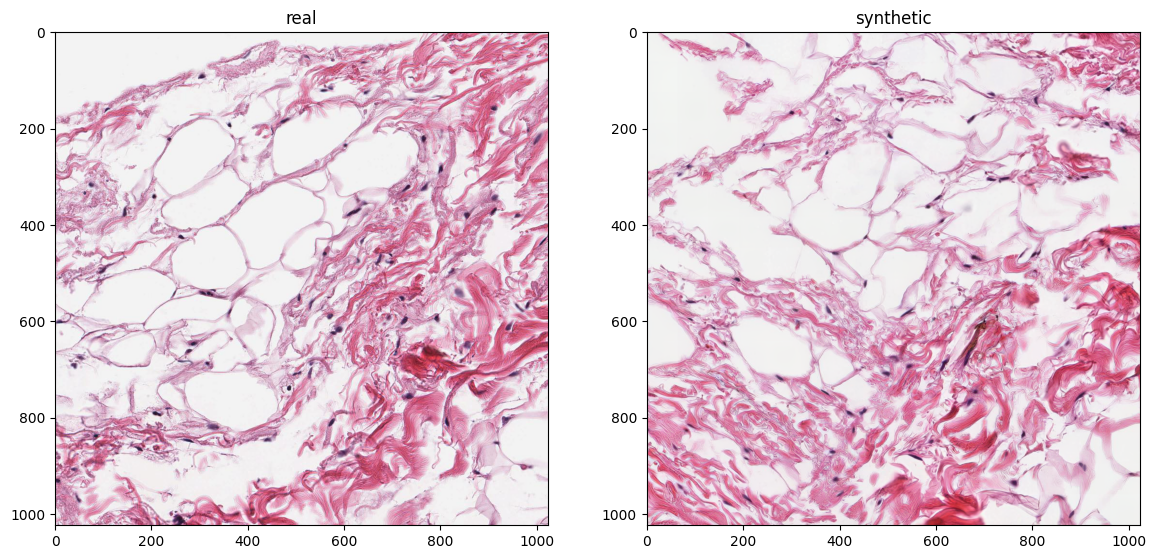

In [34]:
plt.figure(figsize = (14,7))

plt.subplot(1,2,1)
plt.imshow(batch['img_20x_large'])
plt.title('real')

plt.subplot(1,2,2)
plt.imshow(panorama_slerp[0])
plt.title('synthetic')

plt.show()